In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

## Self exciting point process models

These are a class of models which take an explicit statistical model, fit that model to the data, and then uses that fit model to produce a risk intensity, and thus a prediction.

The statistical model is a [Point Process](https://en.wikipedia.org/wiki/Point_process).  The events occurring a split into two classes:

- "Background" events which are modelled as a [Inhomogeneous Poisson Process](https://en.wikipedia.org/wiki/Poisson_point_process#Inhomogeneous_Poisson_point_process).  That is, these events occur randomly in time and space, with the probability of occurrence (a normalise "intensity") varying in time and space, but not depending on past events.
- "Triggered" events which do depend upon the past.  Typically an event will trigger further events with a probability / intensity, typically centred on the trigger event.

This model fits the theoretical pattern of e.g. burglaries whereby a single perhaps "random" event can then lead to repeat events at the same or similar location.

Further readings:

- In the financial mathematics / statistics literature, such processes are called [Hawkes Processes](http://mathworld.wolfram.com/HawkesProcess.html)
- See the introductory notes: [arXiv:1507.02822 [math.PR]](https://arxiv.org/abs/1507.02822)
- Be aware that the term "Hawkes process" can also be used to describe _one specific_ form of the trigger intensity, which is not appropriate to us.
- In Earthquake prediction, such models are also common
- (5) and (6) give some mathematical background to the algorithm described below.

### References:

1. Mohler et al, "Self-Exciting Point Process Modeling of Crime", Journal of the American Statistical Association 2011, DOI:10.1198/jasa.2011.ap09546
2. Ogata, "On Lewis' Simulation Method for Point Processes", IEEE Transactions of Information Theory, 1981.
3. Rasmussen, "Temporal point processes: the conditional intensity function", [Lecture notes](http://people.math.aau.dk/~jgr/teaching/punktproc11/tpp.pdf)
4. Rosser, Cheng, "Improving the Robustness and Accuracy of Crime Prediction with the Self-Exciting Point Process Through Isotropic Triggering" Appl. Spatial Analysis DOI:10.1007/s12061-016-9198-y
5. Veen, Schoenberg, "Estimation of Space-Time Branching Process Models in Seismology Using an EM-Type Algorithm", Journal of the American Statistical Association, 2008, DOI:10.1198/016214508000000148
6. Lewis, Mohler, "A Nonparametric EM algorithm for Multiscale Hawkes Processes" in Proceedings of the 2011 Joint Statistical Meetings, pp. 1–16.  (Preprint available by internet search.)

## Probability theory background

We work with events occuring in two dimensional space, at coordinates $(x,y)$, and at time $t$.  Somethings with think of time as being special, and so a different dimension, and some times we just think of a three dimensional point process in coordinates $(x,y,t)$.

We let $\lambda(x,y,t)$ be the "conditional intensity" of the point processes.  This is defined to be the expected number of events seen in a small region about $(x,y,t)$, divided by the volume of that region, in the limit as the size of the region tends to 0.  Intuitively, a larger intensity means that we are more likely to see events near $(x,y,t)$.

(An intuitive view of probability is the [Frequentist viewpoint](https://en.wikipedia.org/wiki/Probability_interpretations#Frequentism).  If you roll a dice repeatedly, then the statement that the probability of getting a 3 is 1/6 means that, over a large number of repeated trials, you would expect to see the outcome of the dice landing on 3 about 1/6 of the time.  I find it quite hard to an iterpretation of a point process where the _random_ occurrences of past events changes the intensity function, within this framework, because it seems difficult to say exactly what "repeating the process" would mean.  Of course, in the mathematical axiomatisation of modern probability theory, there are of course existence theorems for all the models we will study.)

Our model gives $\lambda$ in the following form.  Let $(x_i,y_i,t_i)$ be the events.  Then

\begin{equation}
\lambda(x,y,t) = \nu(t)\mu(x,y) + \sum_{i : t_i<t} g(t-t_i, x-x_i, y-y_i).
\tag{eq:1}
\end{equation}

Let us explain the two parts:

- $\nu(t)\mu(x,y)$ is the "background intensity".  The model assumes that this factorises into two parts: $\nu(t)$ the time varying component, and $\mu(x,y)$ the space component.
- For example, $\nu(t)$ could vary depending on time of day or the day of the week.
- $\mu(x,y)$ varies to allow certain areas to have a higher likelihood of crime than other areas.
- This form is easier to study than assuming $\mu(x,y,t)$, but does not allow us to model changes which occur in a coupled way in space and time (e.g. a major sporting event near a stadium might increase the intensity of crime in the area and time together).

The sum is taken over all events which occurred _before_ the current time.

- $g$ is a three dimensional intensity function (though only ever evaluated for $t>0$).
- We evaluate it at $g(t-t_i,x-x_i,y-y_i)$, so only the "delta" between the trigger $t_i$ and the next event at $(t,x,y)$ matters.
- Thus the model is that an event at $(t_i,x_i,y_i)$ causes an increase the intensity around this point.
- The increase in intensity is the same for all trigger points-- there is no dependance on the location of the trigger.
- Again, this is a simplifying assumption.  Intuitively, we might expect a model of burgulary crime to have a different "excitation function" $g$ if we were studying burgulary in inner city terrace houses, vs burgulary in low density ex-urban environments.

## Parametric vs non-parametric forms

The original Hawkes process, and self-exciting points processes as used in Earthquake research, are often [Parametric](https://en.wikipedia.org/wiki/Parametric_statistics) in nature, the underlying form of the functions $\nu, mu$ and $g$ coming from theory.

An alternative is to take a [Non-Parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) viewpoint, and estimate the functions using a kernel density estimation (KDE).  This is the approach taken by (1), where a variable bandwidth DKE is used.  Except the following quote from (1) must be made (page 104):

> ... we ﬁnd that for predictive purposes variable bandwidth KDE is less accurate than ﬁxed bandwidth KDE.  We therefore estimate $\mu (x,y)$ in Equation (10) using ﬁxed bandwidth Gaussian KDE.

The reasons given behind this change in methodology are, I believe, an admission that looking at the _local geography_ in which crime is taking place is important.

## Simulation

There are two main simulation methods, both of which treat time as a special variable, and seek to generate events ordered in time.  We should say that, in the abstract, the point processes we are disucssing are not bounded in space or time, and so there is no notion of "start time".  Thus a "perfect" simulation is difficult, as we do not (and cannot) know how far back in time we need to start in order to get an accurate simulation around time zero.  A similar problem obviously occurs in fitting data: if we have data from a relative time of $0$, then events close to $0$ might well be triggered by events before time $0$ (i.e. events we do not know about).  There is a fair amount of theory to suggest that events should not be trigger from _too far in the past_ (order of 2 months is discussed regularly in the literature) and so we shall tacitally ignore such problems

The more general method is a form of [Rejection Sampling](https://en.wikipedia.org/wiki/Rejection_sampling), and is known in the literature as Otago's thinning procedure, see (2).  Suppose we have simulated events at times $t_1 < t_2 < \cdots < t_n$.  We seek a fixed number $\lambda_\max$ such that
$$ \lambda_\max \geq \max_{x,y,t>t_n} \lambda(t,x,y) $$
Let $t_{\text{current}} = t_n$.  We then sample the next point $(t,x,y)$ with $t>{\text{current}}$ from an ordinary, homogeneous Poisson process with intensity $\lambda_\max$.

- We must constrain space to a finite area for this to make sense.
- To speed up the algorithm, we might instead choose a function $\lambda_\max(x,y)$ which dominates $\lambda$ and sample from the time homogeneous, space inhomogeneous process instead.
- We then decide to accept or reject the point: pick uniformly at random $z$ between $0$ and $\lambda_\max$, and then accept if $z\geq \lambda(t,x,y)$.
- If we reject, we try again, but update ${\text{current}}$ to be $t$, so each time we are advancing time.

This method, as with all rejection techniques, can be rather slow.

### Make use of the branching structure

An alternative simulation technique is to notice that the total intensity is _linear_, so each term contributes essentially a new, independent process.  This suggests a simulation strategy reminiscent of a [Branching Process](https://en.wikipedia.org/wiki/Branching_process):

- We firstly simulate an inhomogeous Poisson process with intensity $\nu(t)\mu(x,y)$.  These are the "background events".
- We then iteratively pass over the _all_ the events we have so far generated, in time order.
- Suppose we are now processing an event at $(t_i,x_i,y_i)$.  This will generate further events with intensity $g(t-t_i, x-x_i, y-y_i)$ which we simulate again as an inhomogeneous Poisson process.
- It is important to note that we do not simply simulate the background events, and then allow each of them to trigger extra events.  It is quite allowed that a triggered event itself triggers further events, and so on and so forth.  But each time, the triggered events will be in the future, and so if we only want to simulate a finite time window, we will eventually simulate all events in that window.

# Model fitting

We now describe the optimisation algorithm from (1) (see also the description in (4)).

If we have an estimate for $\nu,\mu$ and $g$ then from (eq:1) we have that
$$ p_{ii} = \frac{\nu(t_i)\mu(x_i,y_i)}{\lambda(t_i,x_i,y_i)} $$
is the probability that event $i$ is a background event, and
$$p_{ji} = \frac{g(t_i-t_j,x_i-x_j,y_i-y_j)}{\lambda(t_i,x_i,y_i)} $$
is the probability that event $j$ triggered event $i$, for $j\leq i$.

(We set $p_{ji}=0$ for $j>i$.  Notice then that $(p_{ij})$ is a upper-triangle matrix, and is a (left) [Stochastic matrix](https://en.wikipedia.org/wiki/Stochastic_matrix).  But we shall not use this.)

We then apply the following optimisation procedure:

1. Take an initial guess for the matrix $P=(p_{ji})$.
2. For each column of $P$, we use the probability distribution to randomly assign event $i$ as a background event (with probability $p_{ii}$) or as an event triggered by a previous event $j<i$ (with probability $p_{ji}$).  This gives a sample of background events $(t_i^b,x_i^b,y_i^b)_{i=1}^{N_b}$ and "inter-point distances" $(t_i^o,x_i^o,y_i^o)_{i=1}^{N_o}$.  That is, if we decide that $i$ triggered $j$ then we set $t_k^o = t_j - t_i, x_k^o = x_j - x_i, y_k^o = y_j - y_i$ for a suitable $k$.  Notice that $N = N_b+N_o$ is a constant, the total number of data points.
3. We then, using whatever method we like, use $(t_i^b,x_i^b,y_i^b)_{i=1}^{N_b}$ to estimate $\nu$ and $\mu$, and use $(t_i^o,x_i^o,y_i^o)_{i=1}^{N_o}$ to estimate $g$.
5. Following (1), we use a variable bandwidth KDE.  Let us discuss $g$ first.  We compute the sample variances of $(t_i^o,x_i^o,y_i^o)_{i=1}^{N_o}$ in each variable separately, say giving $\sigma_t^2, \sigma_x^2, \sigma_y^2$, and rescale so we have unit variance.  From the rescaled data, for each point $i$ we compute the distance to the $k$th nearest neighbour ($k$ is fixed, see later), say giving $D_i$.  Our KDE is then a Gaussian kernel, rescalled appropriately.  That is,
$$ g(t,x,y) = \frac{1}{N} \sum_{i=1}^{N_o} \frac{1}{\sqrt{\sigma_x^2 \sigma_y^2 \sigma_t^2 D_i^6 (2\pi)^3}}
\exp\Big( -\frac{(t-t_i^o)^2}{2\sigma_t^2D_i^2} - \frac{(x-x_i^o)^2}{2\sigma_x^2D_i^2} -
\frac{(y-y_i^o)^2}{2\sigma_y^2D_i^2} \Big). $$
That is, the product of three (uncorrelated) Gaussians with variances $D_i^2\sigma_t^2, D_i^2\sigma_x^2$ and $D_i^2\sigma_y^2$.
6. For $\nu$ we look at just $(t_i^b)_{i=1}^{N_b}$ and for $\mu$ as $(x_i^b,y_i^b)_{i=1}^{N_b}$.
7. Paper (1) used $k=100$ for estimating $\nu$, and $k=15$ when estimating $\mu$ and $g$.  (The larger $k$ is, the more smoothing there is applied to the KDE.)
8. We then use the new estimates of $\nu,\mu$ and $g$ to recompute the matrix $P$, and go back to 2.
9. We find that, in practice, the estimates converge so after a number of iterations we may stop.  (No formal justification is given as to why we expect convergence, nor as to what exactly we converge to.)

### Note on the scaling of the KDEs

Note the scaling factor of $1/N$ in our KDE for $g$, despite the fact we only sum over $N_o$ entries.

When computing the matrix $p$ we only use the ratio between $g$ and $\lambda$ (and that between $\nu\mu$ and $\lambda$) and so if we rescale everything, $p$ doesn't change.

However, the original definition of $\lambda$ means that integrating $\lambda$ over a space-time volume gives the expected number of events in that volume.  The sum of the $g$ kernels corresponds to "triggered" events, and so it is appropriate that if we estimate $N_o$ triggered events, then each $g$ summand should add $N_o/N$ extra intensity.

The calculation for $\nu(t)\mu(x,y)$ is slightly different.  As we have factorised this, we can normalise to assume that $\mu$ is a _probability density function_ giving the probability of crime at a location $(x,y)$, averaged over all time.  Then $\nu(t)$ encodes any time variation, and encodes the total intensity.  If we estimate $N_b$ background events in a time window of length $T$, then we should normalise so that
$$ \int_0^T \nu(t) \ dt = N_b. $$

I _think_ then an appropriate normalisation for $\nu$ would be to initially perform a variable bandwidth KDE on the $N_b$ data points, normalising to get a probability density function.  Then approximately $\int_0^T \nu(t) \ dt = 1$, so we then need to multiply by $N_b$.

# Making predictions

Once we have fitted the model using data in a time window $[0,T]$ we can compute the intensity $\lambda(t,x,y)$ from (eq:1).  If we compute this at $t=T$ we have an exact calculation of the intensity at the instant of time at the end of the "training" dataset.

Suppose we wish to make a prediction at time $t>T$.  We can simply evaluate $\lambda(t,x,y)$, but this would ignore the "self-exciting" nature of the process: there could have been events in the time window $[T,t]$ and these (random) events would increase the intensity $\lambda$.  Two possible options:

1. If $t$ is close to $T$, ignore the problem, and use the intensity $\lambda(T,x,y)$
2. Take a monte-carlo approach, and simulate the events which would occur in $[T,t]$, compute the resulting intensity at time $t$, and then average over a lot of trials to get an average intensity (we could also record standard deviations or other measures).

(We note that other prediction methods, e.g. prospective hot-spotting, suffers from the same issue, but as in that case we don't have an explicit statistical model, it is more obscured.  To be precise, prospective hot-spotting "works" in the sense that events close in space and time predict more events.  If we then try to predict (fairly far) into the future then the logic under-pinning the prediction suggests that more events would occur, especially in high risk areas, and these would have a feed-back effect of increasing the predicted intensity.)

In practise, a big problem here is that the use of kernel density estimation in estimating the _background_ kernel leads to edge effects near $T$.

- One supposes that a more sophisticed modelling procedure could be used which would estimate any _periodic_ behaviour (of which we expect a lot) in the time component of the background kernel.
- If we are simply making _one_ estimation at time $t=T$ then that the time component is estimated badly does not matter, because the "risk" is only ever relative anyway.
- Taking this idea further, we could simply _ignore_ the background time component when making predictions.  This is **currently the approach I take**.
- I have seen no mention of this problem in the literature.

It is, however, important to get the normalisation correct: that is, we use the _average_ (relative) time intensity as our estimate of what the time background component should be at the end-point.

# Some sample data

We start with some artificial data, produced from the actual probability model.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp
import open_cp.sources.sepp
import datetime

In [3]:
region = open_cp.RectangularRegion(xmin=0, xmax=1000, ymin=0, ymax=500)

back_time_kernel = open_cp.sources.sepp.HomogeneousPoisson(10)
back_space_sampler = open_cp.sources.sepp.UniformRegionSampler(region)
background_sampler = open_cp.sources.sepp.InhomogeneousPoissonFactors(
    back_time_kernel, back_space_sampler)

trig_time_kernel = open_cp.sources.sepp.Exponential(exp_rate=10, total_rate=.5)
trig_space_sampler = open_cp.sources.sepp.GaussianSpaceSampler([0,0],[2,2],0)
trigger_sampler = open_cp.sources.sepp.InhomogeneousPoissonFactors(
    trig_time_kernel, trig_space_sampler)

simulation = open_cp.sources.sepp.SelfExcitingPointProcess(background_sampler, trigger_sampler)

In [4]:
sample = simulation.sample(0, 100)
# Scale time from 0...100 to 28 days, at a second resolution
time_unit = open_cp.sources.sepp.make_time_unit(datetime.timedelta(days=28)) / 100
timed_points = open_cp.sources.sepp.scale_to_real_time(sample, datetime.datetime(2016,4,10,0,0),
    time_unit)
timed_points.number_data_points, timed_points.timestamps[0], timed_points.timestamps[-1]

(2025,
 numpy.datetime64('2016-04-10T00:42:20.946'),
 numpy.datetime64('2016-05-07T22:38:39.346'))

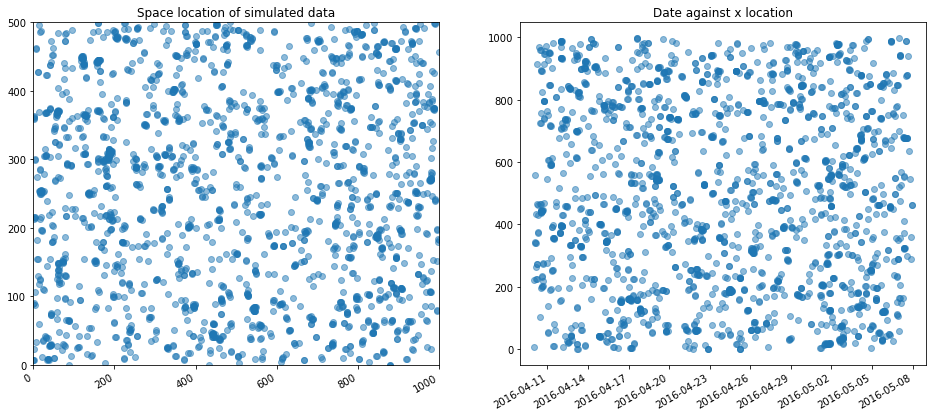

In [5]:
import matplotlib.dates

fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.5)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,1000], ylim=[0,500])

times = timed_points.times_datetime()
ax[1].scatter(times, timed_points.xcoords, alpha=0.5)
ax[1].set_xlim([datetime.datetime(2016,4,9), datetime.datetime(2016,5,9)])
ax[1].set_title("Date against x location")
fig.autofmt_xdate()
None

# Train the predictor

We have chosen the trigger / aftershock kernel to be very tightly clustered in space which helps the estimator.

Unfortunately, the optimisation procedure is rather slow, a fact noticed already by the authors of (4).  To speed it up, we can set "cut offs", space/time distances at which we believe triggering will not occur.  These are set by default to be suitable for real data, but we change them for this simulated data.

The time units get a bit muddled.

- We initially simulate between times 0 and 100, and then rescale to be between 0 and 28 days
- Then internally to the algorithm, we work with a unit of "minutes".
- 28 days = 40,320 minutes so overall we multiply time by 403.2 minutes
- So the aftershock exponential distribution had a rate of 10, so a mean of 0.1, which becomes 40.32, so a new rate of 0.0248015873016
- 3 to 4 hours should be a safe time cutoff

Similarly, the initial background rate of 10 per time unit becomes 10/403.2 per minute

In [6]:
import open_cp.sepp as sepp

In [7]:
trainer = sepp.SEPPTrainer()
trainer.data = timed_points
trainer.space_cutoff = 10
trainer.time_cutoff = datetime.timedelta(hours=5)

In [8]:
predictor = trainer.train()

We can now visualise the space background rate.  In our simulation, this is _uniform_ but we know that the variable bandwidth KDE scheme employed here is likely to be poor at approximating a uniform distribution, due to edge effects.

We also show the estimate for the time rate, which we normalise.  This shows the edge effect problems I describe above.

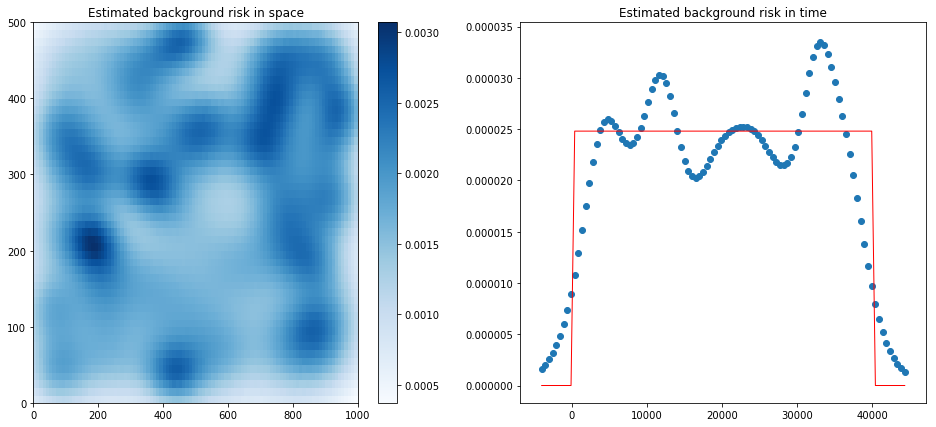

In [9]:
import open_cp.predictors

def plot_density(predictor, ax):
    kernel_array = open_cp.predictors.grid_prediction_from_kernel(predictor.background_kernel.space_kernel,
        region, 10)
    ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
    mesh = ax.pcolormesh(*kernel_array.mesh_data(), kernel_array.intensity_matrix, cmap="Blues")
    fig.colorbar(mesh, ax=ax)
    return kernel_array

fig, ax = plt.subplots(ncols=2, figsize=(16,7))
kernel_array = plot_density(predictor, ax[0])

# Estimated time kernel is _normalised_
total_time = 28*24*60
tc = np.linspace(-total_time * 0.1, total_time * 1.1, 100)
def actual(t):
    return ((t>=0) & (t<=total_time)) / total_time
ax[1].plot(tc, actual(tc), linewidth=1, color="r")
ax[1].scatter(tc, predictor.background_kernel.time_kernel(tc))
ax[0].set_title("Estimated background risk in space")
ax[1].set_title("Estimated background risk in time")
None

The `predictor` has a property `adjusted_background_kernel` which replaces the time component by a constant derived from the average value.

- The intensity is the risk of a crime in unit space and time.
- Space is 1000 * 500 in area, and we calculated an overall rate of 10/403.2 above...

The values below are a sanity check that our normalisations are correct.

In [10]:
print("Average time intensity:", predictor.adjusted_background_kernel.time_kernel(0))
print("Total intensity at (500,250):", predictor.adjusted_background_kernel([0,500,250]))
print("Expected average intensity is:", 10 / 403.2 / (1000 * 500))

Average time intensity: 2.40164788306e-05
Total intensity at (500,250): 3.66458374422e-08
Expected average intensity is: 4.960317460317461e-08


As we have a copy of the estimated "p matrix", we can "stocastically decluster" the points, and get an estimate of which points the algorithm thinks are background events.  This allows us to visualise the KDE procedure more clearly.

In [11]:
backgrounds, aftershocks = sepp.sample_points(trainer.as_time_space_points(), predictor.result.p)

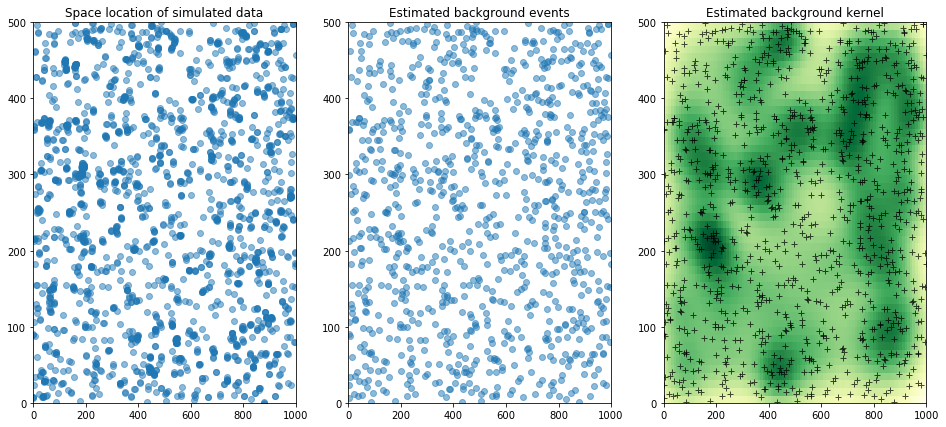

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.5)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,1000], ylim=[0,500])

ax[1].scatter(backgrounds[1], backgrounds[2], alpha=0.5)
ax[1].set_title("Estimated background events")
ax[1].set(xlim=[0,1000], ylim=[0,500])

ax[2].set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
mesh = ax[2].pcolormesh(*kernel_array.mesh_data(), kernel_array.intensity_matrix, cmap="YlGn")
ax[2].set_title("Estimated background kernel")
ax[2].scatter(backgrounds[1], backgrounds[2], marker="+", color="black", alpha=0.7, linewidth=1)
None

It is also extremely interesting to visualise the triggering kernel, and to do this quickly we plot marginals.  By definition, this is accomplished by integrating out 2 of the 3 variables.  As we know the particular form of the kernel estimation used, we can cheat, and quickly compute marginals using some utility methods in the `kernels` package.  For more details, see the "Kernel estimation" notebook, or the "SEPP testbed" notebooks.

In [13]:
def plot_actual_trig_marginals(rate=1/40.32, intensity=0.5, variances=[2,2]):
    def actual_t_marginal(t):
        return intensity * rate * np.exp(-t * rate)
    def actual_x_marginal(x):
        return intensity * np.exp(-x*x/(2*variances[0])) / np.sqrt(2*np.pi*variances[0])
    def actual_y_marginal(y):
        return intensity * np.exp(-y*y/(2*variances[1])) / np.sqrt(2*np.pi*variances[1])

    fig, ax = plt.subplots(ncols=3, figsize=(16,5))

    tc = np.linspace(0, 3.5 / rate, 100)
    actual = actual_t_marginal(tc)
    ax[0].plot(tc, actual, color="red", linewidth=1)

    xl = np.sqrt(variances[0])*4
    xc = np.linspace(-xl, xl, 100)
    actual = actual_x_marginal(xc)
    ax[1].plot(xc, actual, color="red", linewidth=1)

    yl = np.sqrt(variances[1])*4
    yc = np.linspace(-yl, yl, 100)
    actual = actual_y_marginal(yc)
    ax[2].plot(yc, actual, color="red", linewidth=1)

    return ax, tc, xc, yc

def plot_marginals(trigs, rescale, reflect_time=False, intensity=0.5, variances=[2,2], rate=1/40.32):
    ax, tc, xc, yc = plot_actual_trig_marginals(rate, intensity, variances)

    if reflect_time:
        kernel = open_cp.kernels.marginal_knng(trigs, 0)
        td = kernel(tc) + kernel(-tc)
    else:
        td = open_cp.kernels.marginal_knng(trigs, 0)(tc)
    ax[0].scatter(tc, td * rescale)
    ax[1].scatter(xc, open_cp.kernels.marginal_knng(trigs, 1)(xc) * rescale)
    ax[2].scatter(yc, open_cp.kernels.marginal_knng(trigs, 2)(yc) * rescale)
    for i, s in enumerate(list("txy")):
        ax[i].set_title(s+" marginal")

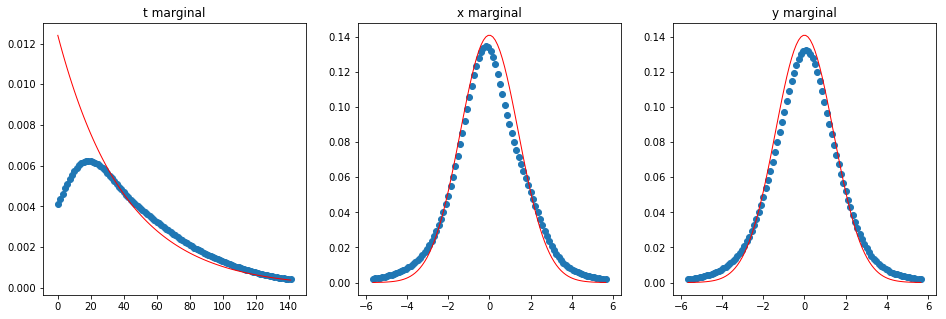

In [14]:
plot_marginals(aftershocks, aftershocks.shape[-1] / timed_points.number_data_points)

We see here the usual pattern for this optimisaition method: slightly heavy tails, due to misclassification of background events as aftershocks.

The estimation of the time marginal is particularly poor:
- This is due to the discontinuity at 0: we know we can have no probability for $t<0$ but the kernel estimation has no knowledge of this.
- It is, of course, somewhat debatably if the exponetial kernel here is a good model for real data: there is likely to be a minimal time gap between (near) repeat victimisation.
- The authors of (4) suggest reflecting the estimated kernel about 0 which we now explore.

At each step of the optimisation procedure, we use the current kernel estimates to inform the next estimate of which events are background and which are aftershocks.  Therefore, to be correct, we should re-run the optimisation process with the new trigger kernel estimator.  As we shall see, this makes little difference to the estimated background events.

In [15]:
trainer.trigger_kernel_estimator = open_cp.kernels.ReflectedKernelEstimator(trainer.trigger_kernel_estimator)
predictor_reflected = trainer.train()

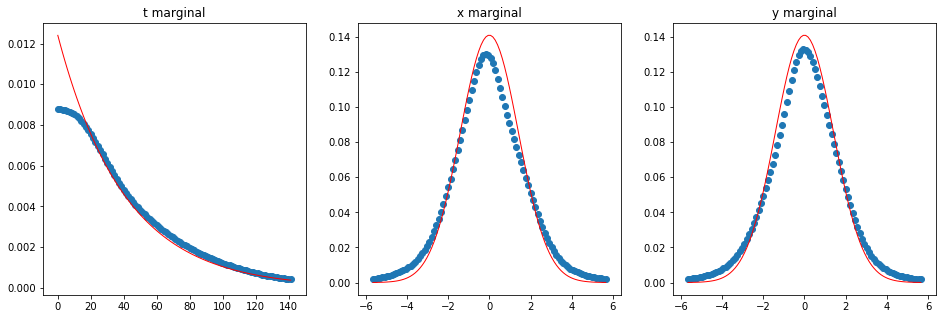

In [16]:
backgrounds, aftershocks = sepp.sample_points(trainer.as_time_space_points(), predictor_reflected.result.p)
plot_marginals(aftershocks, aftershocks.shape[-1] / timed_points.number_data_points, reflect_time=True)

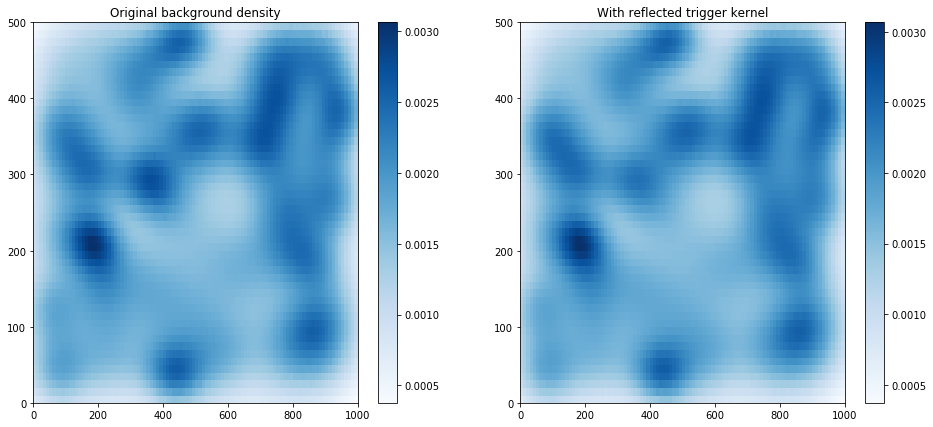

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))
plot_density(predictor, ax[0])
plot_density(predictor_reflected, ax[1])
ax[0].set_title("Original background density")
ax[1].set_title("With reflected trigger kernel")
None

# Make a prediction

Having "trained" the predictor on the data, the "output" is the two kernels, estimating the background rate and the trigger / aftershcok kernel.
- The _time_ component of the background rate might be very interesting to study, but we have _no attempt_ to produce an estimate which can be used for _prediction_ outside the time range of training data.  (Although we see no reason why more sophisticated statistical analysis could not do this.)
- For this reason we ignore the time component of the background kernel when making predictions.

The trained kernels can be applied to any data: past events only affect the current predict through triggering.  Here we shall use the same data and make a prediction for the day after the data.

In [18]:
predictor.data = timed_points
prediction = predictor.predict(datetime.datetime(2016,5,9))

In [19]:
grided = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 20, 20)

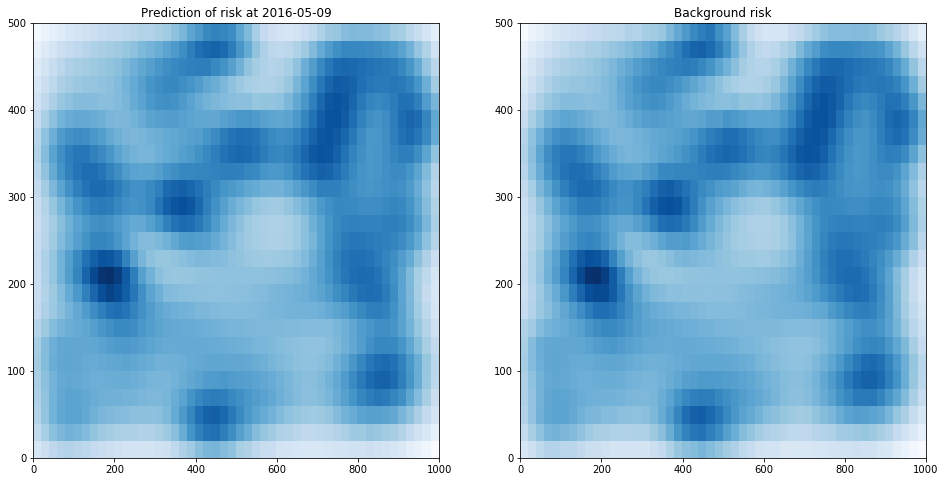

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
ax[0].set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
ax[0].pcolormesh(*grided.mesh_data(), grided.intensity_matrix, cmap="Blues")
ax[0].set_title("Prediction of risk at 2016-05-09")

grided_bground = open_cp.predictors.grid_prediction_from_kernel(predictor.background_kernel.space_kernel,
        region, 20)
ax[1].set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
ax[1].pcolormesh(*grided_bground.mesh_data(), grided_bground.intensity_matrix, cmap="Blues")
ax[1].set_title("Background risk")
None

These look the same!  But that's because the trigger / aftershock kernel decays rather rapidly in time-- on the order of _hours_ for this simulated data.  Making a prediction a whole day after the last event means we just look at the background rate...

In [24]:
prediction = predictor.predict(datetime.datetime(2016,5,8, 0,0))
grided = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 20, 20)

In [25]:
print("Last event occurred at {} at {}".format(timed_points.timestamps[-1], timed_points.coords[:,-1]))
x, y = timed_points.coords[:,-1]
(prediction.risk(x, y), predictor.adjusted_background_kernel([0,x, y]),
prediction.risk(x, y) / predictor.adjusted_background_kernel([0,x, y]))

Last event occurred at 2016-05-07T22:38:39.346 at [ 462.46916364   74.3047716 ]


(array([ 0.00019442]), 5.2697551979129865e-08, array([ 3689.39438209]))

So in this case we do see an increase in risk against the background.

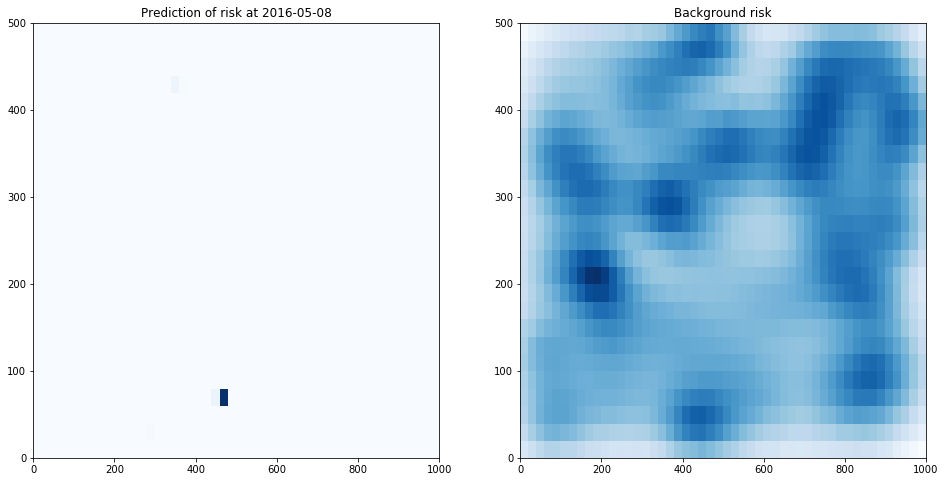

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
ax[0].set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
ax[0].pcolormesh(*grided.mesh_data(), grided.intensity_matrix, cmap="Blues")
ax[0].set_title("Prediction of risk at 2016-05-08")

ax[1].set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
ax[1].pcolormesh(*grided_bground.mesh_data(), grided_bground.intensity_matrix, cmap="Blues")
ax[1].set_title("Background risk")
None

# For a second time, with more "realistic" parameters

Here we simulate a lower background rate, but a more intense "aftershock" distribution, which is also more spread out in space.

In [27]:
region = open_cp.RectangularRegion(xmin=0, xmax=1000, ymin=0, ymax=1000)

back_time_kernel = open_cp.sources.sepp.HomogeneousPoisson(1)
back_space_sampler = open_cp.sources.sepp.UniformRegionSampler(region)
background_sampler = open_cp.sources.sepp.InhomogeneousPoissonFactors(
    back_time_kernel, back_space_sampler)

trig_time_kernel = open_cp.sources.sepp.Exponential(exp_rate=0.5, total_rate=0.8)
trig_space_sampler = open_cp.sources.sepp.GaussianSpaceSampler([0,0],[20,20],0)
trigger_sampler = open_cp.sources.sepp.InhomogeneousPoissonFactors(
    trig_time_kernel, trig_space_sampler)

simulation = open_cp.sources.sepp.SelfExcitingPointProcess(background_sampler, trigger_sampler)

In [28]:
sample = simulation.sample(0, 365)
time_unit = open_cp.sources.sepp.make_time_unit(datetime.timedelta(days=1))
timed_points = open_cp.sources.sepp.scale_to_real_time(sample, datetime.datetime(2017,1,1,0,0),
    time_unit)
timed_points.number_data_points, timed_points.timestamps[0], timed_points.timestamps[-1]

(1885,
 numpy.datetime64('2017-01-01T20:48:30.395'),
 numpy.datetime64('2017-12-31T22:26:45.764'))

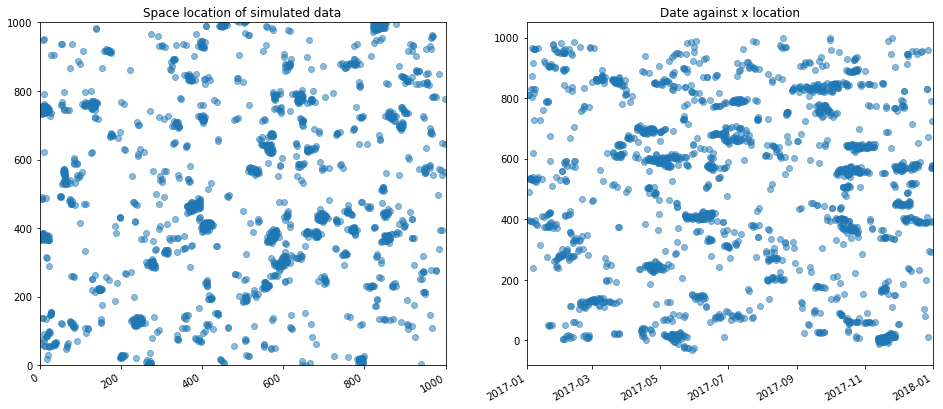

In [29]:
import matplotlib.dates

fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.5)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,1000], ylim=[0,1000])

times = timed_points.times_datetime()
ax[1].scatter(times, timed_points.xcoords, alpha=0.5)
ax[1].set_xlim([datetime.datetime(2017,1,1), datetime.datetime(2018,1,1)])
ax[1].set_title("Date against x location")
fig.autofmt_xdate()
None

In [30]:
trainer = sepp.SEPPTrainer()
trainer.data = timed_points
trainer.space_cutoff = 100
trainer.time_cutoff = datetime.timedelta(days=10)
predictor = trainer.train()

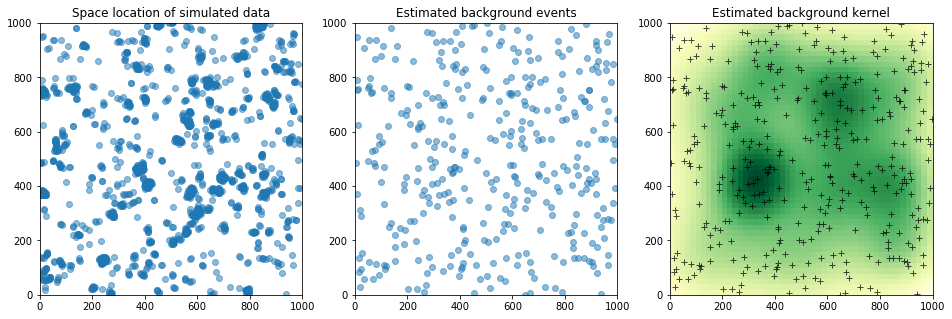

In [31]:
backgrounds, aftershocks = sepp.sample_points(trainer.as_time_space_points(), predictor.result.p)

fig, ax = plt.subplots(ncols=3, figsize=(16,5))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.5)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,1000], ylim=[0,1000])

ax[1].scatter(backgrounds[1], backgrounds[2], alpha=0.5)
ax[1].set_title("Estimated background events")
ax[1].set(xlim=[0,1000], ylim=[0,1000])

ax[2].set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
kernel_array = open_cp.predictors.grid_prediction_from_kernel(predictor.background_kernel.space_kernel,
    region, 20)
mesh = ax[2].pcolormesh(*kernel_array.mesh_data(), kernel_array.intensity_matrix, cmap="YlGn")
ax[2].set_title("Estimated background kernel")
ax[2].scatter(backgrounds[1], backgrounds[2], marker="+", color="black", alpha=0.7, linewidth=1)
None

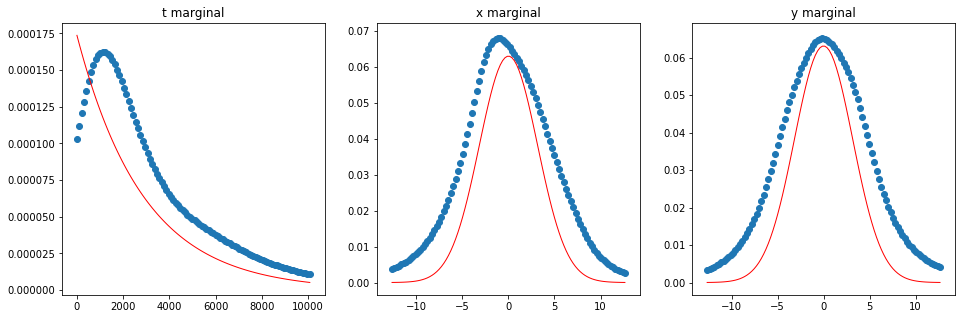

In [32]:
aftershock_rate = 0.5
mean_days = 1 / aftershock_rate
mean_minutes = 24 * 60 * mean_days
rate_in_minutes = 1 / mean_minutes

plot_marginals(aftershocks, aftershocks.shape[-1] / timed_points.number_data_points,
               rate = rate_in_minutes, intensity=0.5, variances=[10,10])

In [33]:
predictor.data = timed_points
dates = [datetime.datetime(2018,1,1) + datetime.timedelta(hours=30*i) for i in range(9)]
predictions = [predictor.predict(d) for d in dates]
grided = [open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(pr, region, 40, 40)
          for pr in predictions]

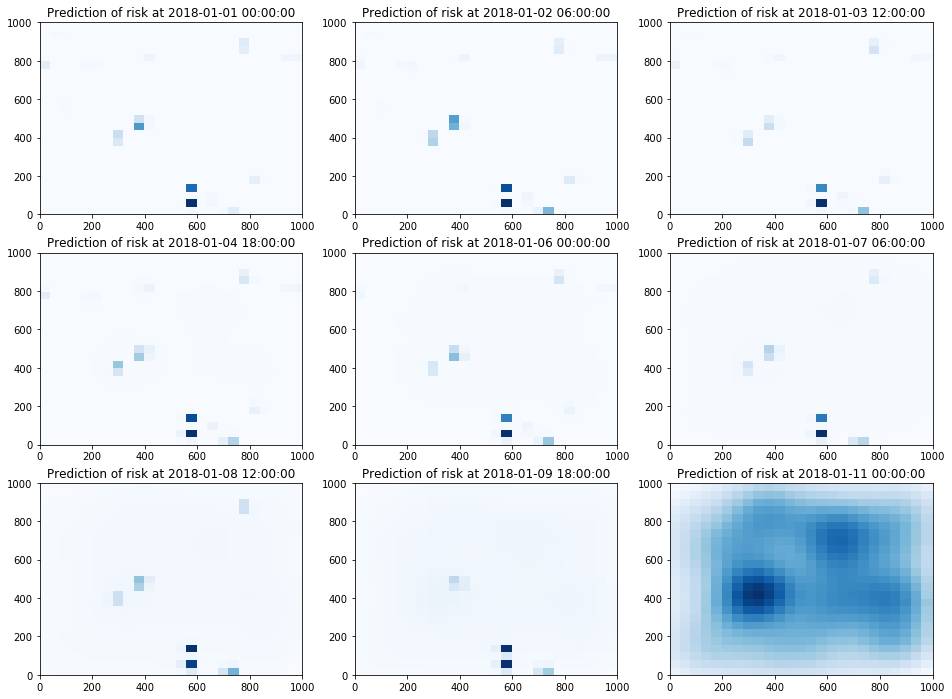

In [34]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(16,12))
for i, ax in enumerate(axes.ravel()):
    ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
    ax.pcolormesh(*grided[i].mesh_data(), grided[i].intensity_matrix, cmap="Blues")
    ax.set_title("Prediction of risk at {}".format(dates[i]))


We see here a somewhat different "problem": the aftershock risk completely dominates the background risk!

It would obviously be very interesting to look at real data.